In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from joblib import dump, load

In [2]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok= True)

In [4]:
df = pd.read_csv('B0005_discharge.csv')
print(df.head(100))

    cycle  ambient_temperature  capacity  voltage_measured  current_measured  \
0       1                   24  1.856487          4.191492         -0.004902   
1       1                   24  1.856487          4.190749         -0.001478   
2       1                   24  1.856487          3.974871         -2.012528   
3       1                   24  1.856487          3.951717         -2.013979   
4       1                   24  1.856487          3.934352         -2.011144   
..    ...                  ...       ...               ...               ...   
95      1                   24  1.856487          3.537401         -2.013064   
96      1                   24  1.856487          3.535187         -2.011051   
97      1                   24  1.856487          3.532509         -2.012815   
98      1                   24  1.856487          3.529903         -2.014840   
99      1                   24  1.856487          3.527548         -2.012969   

    temperature_measured  current_load 

In [7]:
test = df[['cycle','capacity']].copy().drop_duplicates()
print(type(test))
print(test)


<class 'pandas.core.frame.DataFrame'>
       cycle  capacity
0          1  1.856487
197        2  1.846327
393        3  1.835349
588        4  1.835263
782        5  1.834646
...      ...       ...
48796    164  1.293464
49093    165  1.288003
49390    166  1.287453
49687    167  1.309015
49985    168  1.325079

[168 rows x 2 columns]


In [8]:
# x = test['cycle'].values
# y = test['capacity'].values
# plt.figure(figsize=(8,6))
# plt.plot(x,y,label = 'True')
# plt.xlabel('cycle')
# plt.ylabel('capacity/Ah')
# plt.legend()
# plt.xlim(0, 180)
# plt.ylim(1.2, 1.9)
# plt.plot([0,168],[1.4,1.4], color='purple', linestyle='--')

In [ ]:
split_threshold = 90

train_capacity = test[test['cycle'] <= split_threshold]['capacity'].values # Pandas -> numpy 
test_capacity = test[test['cycle'] > split_threshold]['capacity'].values

print(type(train_capacity))
print(train_capacity,'\n')
print(test_capacity,'\n')
print(train_capacity.shape,'\n')
print(train_capacity.reshape(-1,1).shape)

<class 'numpy.ndarray'>
[1.85648742 1.84632725 1.83534919 1.83526253 1.83464551 1.83566166
 1.83514614 1.82575679 1.82477385 1.82461327 1.82461955 1.81420194
 1.81375216 1.81344049 1.802598   1.8021069  1.8025795  1.80306831
 1.80277762 1.84702599 1.84741731 1.83617742 1.82578075 1.82511364
 1.8255815  1.81403113 1.81476919 1.81396939 1.80276567 1.80407704
 1.85180255 1.83070385 1.81990411 1.80930796 1.8046099  1.79937707
 1.78844323 1.78292305 1.77303372 1.77303776 1.76787211 1.76231507
 1.76761729 1.76266836 1.75173049 1.7418496  1.73609135 1.79362401
 1.78318902 1.76736421 1.75701779 1.74687062 1.74171725 1.73642251
 1.72632172 1.71580654 1.71053335 1.7060145  1.70031103 1.69457986
 1.68490291 1.67447416 1.67456925 1.66371638 1.65901387 1.65385406
 1.64265378 1.63785784 1.63273504 1.62775289 1.62212549 1.61132566
 1.60656314 1.60151422 1.59036923 1.585789   1.58494307 1.59552639
 1.57473017 1.564902   1.55976595 1.55948157 1.55468935 1.54887411
 1.5382366  1.52791426 1.52852526 1.52

In [30]:
scaler = MinMaxScaler()
# 1D数组 -> 2D列向量(samples, feature) -> 1D数组
train_capacity_scaled = scaler.fit_transform(train_capacity.reshape(-1,1)).flatten() 
test_capacity_scaled = scaler.transform(test_capacity.reshape(-1,1)).flatten()

print(train_capacity_scaled)
print(test_capacity_scaled)

[1.         0.97002912 0.93764561 0.93738996 0.93556985 0.93856734
 0.93704664 0.90934955 0.90645005 0.90597635 0.90599488 0.87526458
 0.87393781 0.87301844 0.84103484 0.83958616 0.84098026 0.84242218
 0.84156469 0.97209031 0.97324463 0.94008875 0.90942022 0.90745237
 0.90883249 0.87476072 0.8769379  0.8745786  0.84152941 0.84539776
 0.98618039 0.92394258 0.89208508 0.86082815 0.84696962 0.83153358
 0.79928053 0.78299687 0.75382492 0.75383683 0.73859901 0.72220663
 0.73784733 0.72324877 0.6909838  0.66183677 0.64485085 0.814563
 0.78378145 0.73710077 0.70658048 0.67664796 0.66144635 0.6458277
 0.61603201 0.58501389 0.56945883 0.55612894 0.53930461 0.52239859
 0.49385313 0.46308998 0.46337048 0.43135624 0.4174846  0.40226398
 0.36922496 0.35507771 0.33996626 0.32526972 0.30866977 0.27681201
 0.26276334 0.24786984 0.2149939  0.20148294 0.19898759 0.23020669
 0.16886118 0.13986962 0.1247191  0.12388022 0.10974396 0.09258992
 0.06121097 0.03076171 0.03256408 0.0152251  0.         0.2605679

In [37]:
def create_sequences(data, seq_length=5):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])  # 前5个历史容量数据作为输入
        y.append(data[i+seq_length])    # 第6个数据作为目标
    return np.array(x), np.array(y)

In [38]:
X_train, y_train = create_sequences(train_capacity_scaled, seq_length=5)
X_test, y_test = create_sequences(test_capacity_scaled, seq_length=5) 

print(X_train.shape)
print(y_train.shape)

(85, 5)
(85,)


In [39]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1)
print(X_train,'\n')
print(X_train.shape)

[[[[1.        ]
   [0.97002912]
   [0.93764561]
   [0.93738996]
   [0.93556985]]]


 [[[0.97002912]
   [0.93764561]
   [0.93738996]
   [0.93556985]
   [0.93856734]]]


 [[[0.93764561]
   [0.93738996]
   [0.93556985]
   [0.93856734]
   [0.93704664]]]


 [[[0.93738996]
   [0.93556985]
   [0.93856734]
   [0.93704664]
   [0.90934955]]]


 [[[0.93556985]
   [0.93856734]
   [0.93704664]
   [0.90934955]
   [0.90645005]]]


 [[[0.93856734]
   [0.93704664]
   [0.90934955]
   [0.90645005]
   [0.90597635]]]


 [[[0.93704664]
   [0.90934955]
   [0.90645005]
   [0.90597635]
   [0.90599488]]]


 [[[0.90934955]
   [0.90645005]
   [0.90597635]
   [0.90599488]
   [0.87526458]]]


 [[[0.90645005]
   [0.90597635]
   [0.90599488]
   [0.87526458]
   [0.87393781]]]


 [[[0.90597635]
   [0.90599488]
   [0.87526458]
   [0.87393781]
   [0.87301844]]]


 [[[0.90599488]
   [0.87526458]
   [0.87393781]
   [0.87301844]
   [0.84103484]]]


 [[[0.87526458]
   [0.87393781]
   [0.87301844]
   [0.84103484]
   [0.839586

In [40]:
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)  # label -> 2D
y_test_tensor = torch.tensor(y_test, dtype =torch.float32).view(-1,1)
print(X_train_tensor.shape) 
print(y_train_tensor.shape)

torch.Size([85, 1, 5, 1])
torch.Size([85, 1])


In [41]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)    # 随机取

print(train_dataset[0],'\n')
print(len(train_dataset),'\n')
print(len(train_loader))

(tensor([[[1.0000],
         [0.9700],
         [0.9376],
         [0.9374],
         [0.9356]]]), tensor([0.9386])) 

85 

6


In [ ]:
class BatteryCapacityConvNet2D(nn.Module):
    def __init__(self):
        super(BatteryCapacityConvNet2D, self).__init__()
        '''
        二维卷积神经网络
        Input data size: [Batch_size, In_channels, Height, Width]
        Output data size: [Batch_size, Out_channels, Height, Width]
        H_out = [H_in + 2 * padding_H - dilation_H * (Kernel_size_H - 1) -1] / stride_H + 1
        W_out = ...
        '''
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size= (3,1), stride=(1,1), padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3,1), stride=(1,1), padding=0),
            nn.BatchNorm2d(20),
            nn.ReLU()
        )

        self.fc = nn.Linear(20, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [48]:
model = BatteryCapacityConvNet2D().to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

best_val_loss = float('inf')
best_epoch = 0
train_losses = []
val_losses = []
for epoch in range(1000):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:  # len(train_loader) = samples/batch_size次迭代
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_tensor.to(device))
        val_loss = criterion(val_pred, y_test_tensor.to(device))
        val_losses.append(val_loss.item())
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pth'))
        dump(scaler, os.path.join(model_dir, 'scaler.joblib'))
    
    scheduler.step()
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/1000], Train Loss: {avg_epoch_loss:.6f}, \
              Val Loss: {val_loss.item():.6f}, Best Val Loss: {best_val_loss:.6f} (Epoch {best_epoch+1})")

BatteryCapacityConvNet2D(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 1), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 1), stride=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Linear(in_features=20, out_features=1, bias=True)
)
Epoch [100/1000], Train Loss: 0.009497,               Val Loss: 0.007379, Best Val Loss: 0.002029 (Epoch 51)
Epoch [200/1000], Train Loss: 0.019924,               Val Loss: 0.001215, Best Val Loss: 0.001215 (Epoch 200)
Epoch [300/1000], Train Loss: 0.007928,               Val Loss: 0.012307, Best Val Loss: 0.001123 (Epoch 239)
Epoch [400/1000], Train Loss: 0.002982,               Val Loss: 0.014783, Best Val Loss: 0.001123 (Epoch 239)
Epoch [500/1000], Train Loss: 0.009946,               Val Loss: 0.013354, Best Val Loss: 0.001

Text(0.5, 1.0, 'Training History')

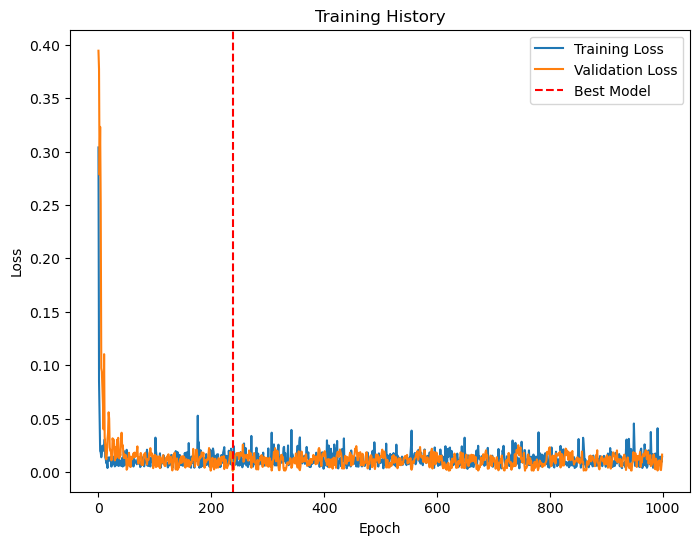

In [49]:
plt.figure(figsize = (8,6))
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.axvline(x=best_epoch, color = 'r', linestyle='--', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')

In [50]:
best_model = BatteryCapacityConvNet2D().to(device)
best_model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pth')))
best_model.eval()

loaded_scaler = load(os.path.join(model_dir, 'scaler.joblib'))

In [ ]:
with torch.no_grad():
    y_pred_scaled = best_model(X_test_tensor.to(device)).cpu()
    y_train_pred_scaled = best_model(X_train_tensor.to(device)).cpu()

    # Rescale
    y_pred = loaded_scaler.inverse_transform(y_pred_scaled.numpy()) #.numpy() converts tensor -> numpy
    y_train_pred = loaded_scaler.inverse_transform(y_train_pred_scaled.numpy())

    test_rmse = np.sqrt(mean_squared_error(test_capacity[5:], y_pred))
    test_mae = mean_absolute_error(test_capacity[5:], y_pred)
    test_mape = mean_absolute_percentage_error(test_capacity[5:], y_pred)
    train_rmse = np.sqrt(mean_squared_error(train_capacity[5:], y_train_pred))

    print(f'\nBest Model Performance:')
    # print(f'Best Epoch: {best_epoch + 1}')
    print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MAPE: {test_mape: .4f}')
    print(f'Train RMSE: {train_rmse:.4f}')



Best Model Performance:
Test RMSE: 0.0114, Test MAE: 0.0082
Train RMSE: 0.0183


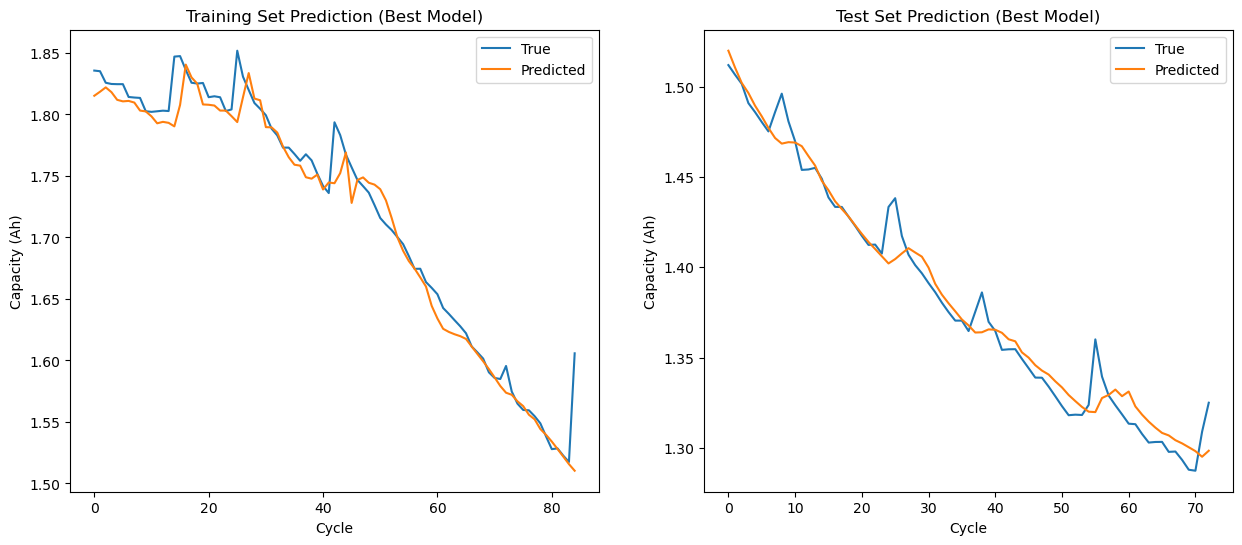

In [52]:
plt.figure(figsize=(15,6))

# 训练集结果
plt.subplot(1,2,1)
plt.plot(train_capacity[5:], label='True')
plt.plot(y_train_pred, label='Predicted')
plt.title('Training Set Prediction (Best Model)')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()

# 测试集结果
plt.subplot(1,2,2)
plt.plot(test_capacity[5:], label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Test Set Prediction (Best Model)')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()

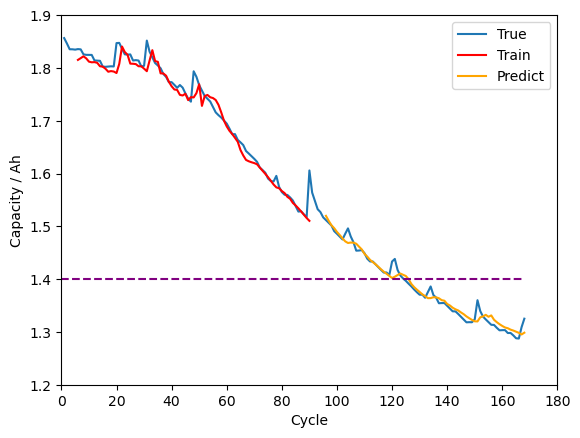

In [69]:
plt.plot(x,y, label = 'True')
plt.plot(x[5:split_threshold], y_train_pred, label='Train', color = 'r')
plt.plot(x[split_threshold+5:], y_pred, label='Predict', color = 'orange')
plt.plot([0,168],[1.4,1.4],color = 'purple', linestyle = '--')
plt.xlim(0,180)
plt.ylim(1.2,1.9)
plt.xlabel('Cycle')
plt.ylabel('Capacity / Ah')

plt.legend()